# Solving Mumford-Shah Functional using the Ambrosio-Tortorelli Minimizer

Modified from https://github.com/jacobgil/Ambrosio-Tortorelli-Minimizer

In [1]:
import cv2
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator
import os
from matplotlib import pyplot as plt

In [2]:
cv2.__version__

'4.5.3'

## AmbrosioTortorelliMinimizer Class

In [3]:
class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()		
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)


In [4]:
def show_image(image):
    plt.figure(figsize=(10,10))
    img = image * 1
    cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
    img = np.uint8(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Get your input image

In [5]:
img = cv2.imread((os.path.join('data','mona-lisa.png')))

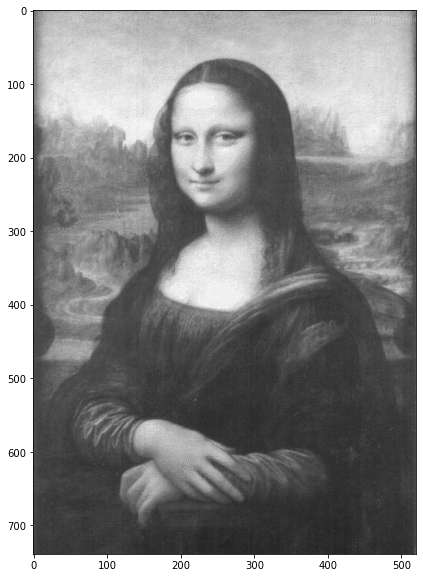

In [6]:
show_image(img)

Run Ambrosio-Tortorelli Minimizer to solve Mumford-Shah Functional

In [7]:
result, edges = [], []

for channel in cv2.split(img):
		solver = AmbrosioTortorelliMinimizer(channel, iterations = 1, tol = 0.1, solver_maxiterations = 6)
		f, v = solver.minimize()
		result.append(f)
		edges.append(v)

In [8]:
f.shape

(739, 520)

In [9]:
v.shape

(739, 520)

Plot image smoothed by Mumford-Shah

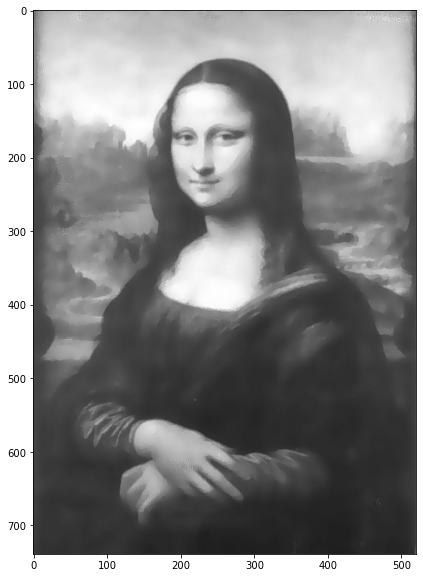

In [10]:
plt.figure(figsize=(10,10))
height, width = f.shape
nf = np.zeros((height,width), np.uint8)
cv2.normalize(f,nf,0,255,cv2.NORM_MINMAX)
nf = np.uint8(nf)
plt.imshow(f, cmap = 'gray')

Show edges from solver

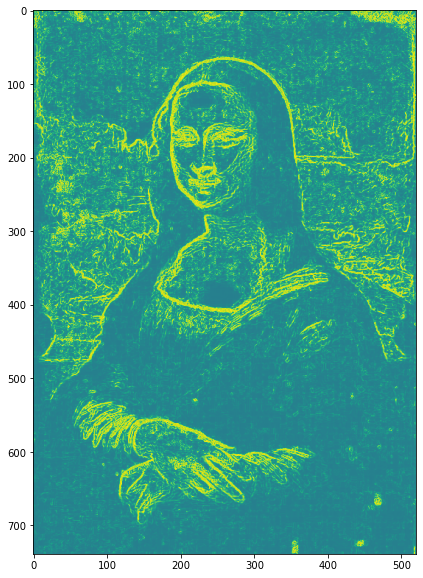

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(v)